In [115]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW

In [116]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
df_divisas = pd.read_csv("/content/drive/MyDrive/Divisas/monedas_completo.csv")

In [118]:
df_divisas

,fecha,moneda,valor
0,2025-10-01,USD,1.173379
1,2025-10-01,COP,4553.307498
2,2025-10-01,MXN,21.574520
3,2025-09-30,USD,1.173530
4,2025-09-30,COP,4607.867346
...,...,...,...
430,2025-05-12,COP,4687.369980
431,2025-05-12,MXN,21.771759
432,2025-05-11,USD,1.122926
433,2025-05-11,COP,4770.977372


Pivoteando para hacer las monedas columnas

In [119]:
df_divisas = df_divisas.pivot_table(values="valor", columns="moneda",index="fecha").reset_index()
df_divisas

moneda,fecha,COP,MXN,USD
0,2025-05-11,4770.977372,21.834844,1.122926
1,2025-05-12,4687.369980,21.771759,1.109502
2,2025-05-13,4710.919431,21.708052,1.118518
3,2025-05-14,4703.826909,21.676348,1.118162
4,2025-05-15,4702.452110,21.806607,1.119232
...,...,...,...,...
139,2025-09-27,4556.938619,21.490324,1.170254
140,2025-09-28,4566.956741,21.496285,1.170681
141,2025-09-29,4599.499346,21.540663,1.173117
142,2025-09-30,4607.867346,21.495540,1.173530


Se separa la fecha en dia,mes y año

In [120]:
df_divisas["fecha"] = pd.to_datetime(df_divisas["fecha"])
df_divisas["Dia"] = df_divisas["fecha"].dt.day
df_divisas["Mes"] = df_divisas["fecha"].dt.month
df_divisas["Año"] = df_divisas["fecha"].dt.year
df_divisas = df_divisas.sort_values('fecha')


In [121]:
df_divisas

moneda,fecha,COP,MXN,USD,Dia,Mes,Año
0,2025-05-11,4770.977372,21.834844,1.122926,11,5,2025
1,2025-05-12,4687.369980,21.771759,1.109502,12,5,2025
2,2025-05-13,4710.919431,21.708052,1.118518,13,5,2025
3,2025-05-14,4703.826909,21.676348,1.118162,14,5,2025
4,2025-05-15,4702.452110,21.806607,1.119232,15,5,2025
...,...,...,...,...,...,...,...
139,2025-09-27,4556.938619,21.490324,1.170254,27,9,2025
140,2025-09-28,4566.956741,21.496285,1.170681,28,9,2025
141,2025-09-29,4599.499346,21.540663,1.173117,29,9,2025
142,2025-09-30,4607.867346,21.495540,1.173530,30,9,2025


Funcion que filtra por mes y grafica por dia del mes seleccionado para la moneda deseada



In [122]:
def grafica_dias_del_mes(moneda: str, mes: int):
    df_dias_mes = df_divisas.loc[df_divisas["Mes"] == mes]
    plt.figure(figsize=(14,8))
    sns.lineplot(data=df_dias_mes, x="Dia", y=moneda)
    plt.title(f"Evolución de {moneda} en el mes {mes} del año 2025")
    plt.xlabel("Día")
    plt.ylabel(moneda)
    plt.show()


Grafica por dias de COP en el mes 6(junio)

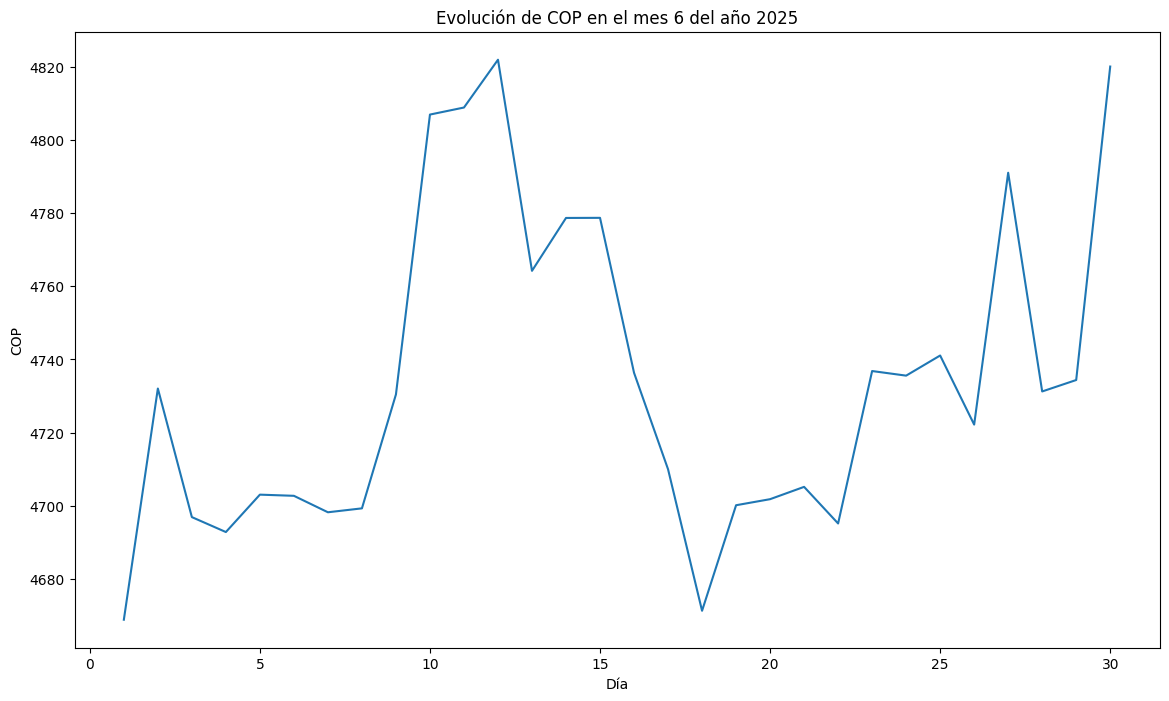

In [123]:
grafica_dias_del_mes("COP",6)

Grafica por dias de USD en el mes 8(agosto)

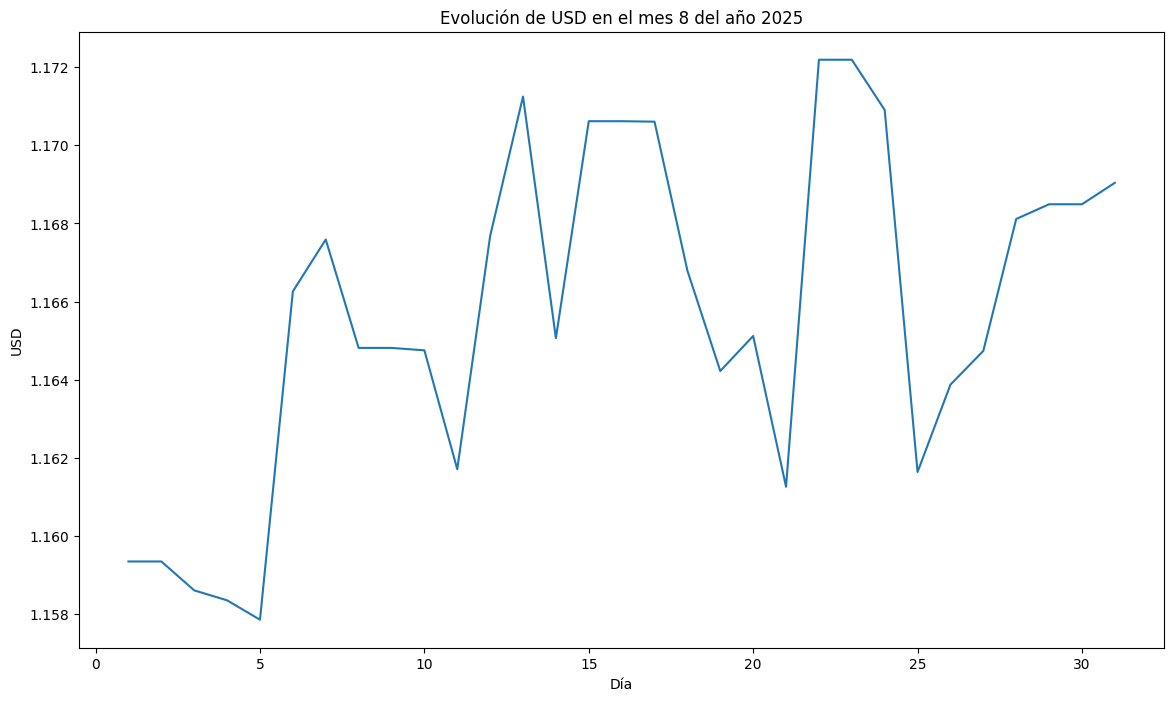

In [124]:
grafica_dias_del_mes("USD",8)

Grafica por dias de MXN en el mes 7(julio)

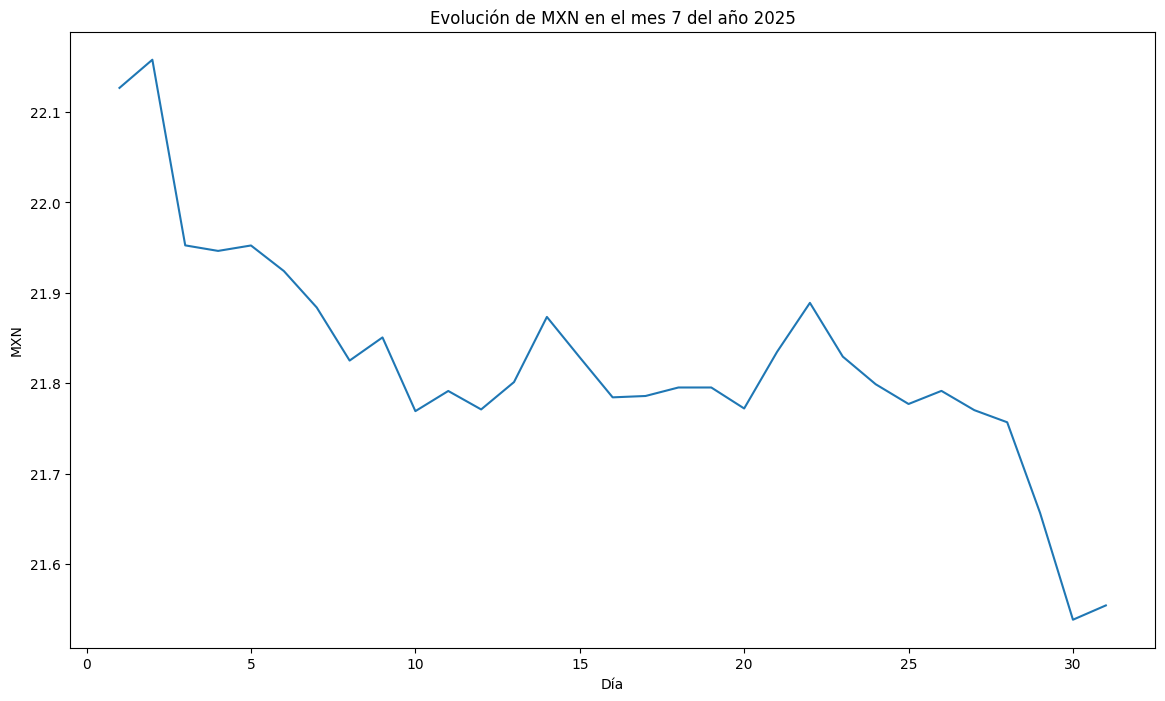

In [125]:
grafica_dias_del_mes("MXN",7)

Ahora se usará una red LSTM para predecir los precios de COP según USD

In [126]:
scaler_usd = MinMaxScaler()
scaler_cop = MinMaxScaler()

usd_escalada = scaler_usd.fit_transform(df_divisas[["USD"]])
cop_escalada = scaler_cop.fit_transform(df_divisas[["COP"]])


data_escalada = np.hstack((usd_escalada, cop_escalada))

In [127]:
def crear_secuencias_con_fechas(dataset, fechas, pasos):
    X, y, fechas_y = [], [], []
    for i in range(pasos, len(dataset)):
        X.append(dataset[i - pasos:i, 0])   # USD últimos 'pasos' días
        y.append(dataset[i, 1])             # COP actual
        fechas_y.append(fechas[i])          # Fecha del valor de salida
    return np.array(X), np.array(y), np.array(fechas_y)


In [140]:
dias_previos = 30  #días previos de USD para predecir COP
X, y, fechas_y = crear_secuencias_con_fechas(data_escalada, df_divisas['fecha'].values, dias_previos)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [141]:
X = X.reshape((X.shape[0], X.shape[1], 1))

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
fechas_train, fechas_test = fechas_y[:train_size], fechas_y[train_size:]


In [142]:

modelo = Sequential([
    # Primera capa LSTM
    LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.2),

    # Segunda capa LSTM
    LSTM(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),

    # Tercera capa LSTM
    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.2),

    # Capas densas intermedias
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),

    # Capa de salida
    Dense(1)
])

modelo.compile(optimizer=AdamW(learning_rate=0.0007), loss='mse', metrics=['mae'])

modelo.summary()

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=12,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-8
)


history = modelo.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

pred = modelo.predict(X_test)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_84 (LSTM)                  │ (None, 30, 256)        │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_75          │ (None, 30, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_85 (LSTM)                  │ (None, 30, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_86 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 518,785 (1.98 MB)

 Trainable params: 517,889 (1.98 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 617ms/step - loss: 0.5450 - mae: 0.5555 - val_loss: 0.0095 - val_mae: 0.0819 - learning_rate: 7.0000e-04
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - loss: 0.2547 - mae: 0.4006 - val_loss: 0.0072 - val_mae: 0.0697 - learning_rate: 7.0000e-04
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step - loss: 0.2497 - mae: 0.3669 - val_loss: 0.0063 - val_mae: 0.0651 - learning_rate: 7.0000e-04
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - loss: 0.1657 - mae: 0.3275 - val_loss: 0.0067 - val_mae: 0.0671 - learning_rate: 7.0000e-04
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 487ms/step - loss: 0.2585 - mae: 0.3932 - val_loss: 0.0071 - val_mae: 0.0691 - learning_rate: 7.0000e-04
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 415ms/step - loss: 0.1329 - mae: 0.2765 - val_loss: 0.0065 - val_mae: 0.0659 - learning_rate: 7.0000e-04
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 405ms/step - loss: 0.0816 - mae: 0.2178 - val_loss: 0.0065 - val_mae: 0.0659 - learning_rate: 7.

In [143]:
y_test_inv = scaler_cop.inverse_transform(y_test.reshape(-1,1))
pred_inv = scaler_cop.inverse_transform(pred)

mae_real = mean_absolute_error(y_test_inv, pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, pred_inv))
r2 = r2_score(y_test_inv, pred_inv)

print(f"RMSE: {rmse:.2f} COP")
print(f"R²: {r2:.4f}")
print(f"MAE real: {mae_real:.2f} COP")

RMSE: 16.41 COP
R²: 0.0024
MAE real: 14.20 COP


**CONCLUSIONES**

* El modelo logra errores absolutos bajos (≈ 14 COP), lo que indica buena precisión promedio en el corto plazo.

* El R² cercano a cero sugiere que la LSTM aún no captura bien la variabilidad total del COP — predice valores cercanos al promedio o sigue la tendencia general, pero no explica gran parte de las fluctuaciones, esto sugiere añadir mas variables al modelo(otros tipo de indicadores economicos)

* El RMSE y MAE son consistentes, lo que indica estabilidad del modelo (sin errores extremos grandes).

